In [49]:
import sys
sys.path.append('/home/addis/Pylians3/library/build/lib.linux-x86_64-3.8')
import numpy as np
import Pk_library as PKL
from numba import jit
import readgadget
import MAS_library as MASL
import redshift_space_library as RSL

#field things!
path = '../../../data/Quijote/' #path to folder containing quijote files.
N_side = 128
rsd_direction = '' # 'z'

redshift = '/snapdir_004/snap_004'
if redshift[-1] == str(4):
    red_info = 'z=0'
elif redshift[-1] == str(2):
    red_info = 'z=1'
else:
    red_info = 'z=NA'

In [50]:
file= str(10000) + redshift
# input files   # so we enter the Quijote folder and access which initialization
snapshot = path + file  #10000/snapdir_004/snap_004
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

# read header
header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)*(1/(1+redshift))#Value of (conformal) H(z) in km/s/(Mpc/h)

# read positions, velocities and IDs of the particles
pos = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
vel = readgadget.read_block(snapshot, "VEL ", ptype)     #peculiar velocities in km/s
ids = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0

In [59]:
"""Create 27 cube megacube"""
#but first lets down sample
in_bool = np.where(np.random.random(len(pos))>0.965)
pos_sample = pos[in_bool]
vel_sample = vel[in_bool]
extra_boxes = np.zeros((27,*pos_sample.T.shape),dtype=np.float32) #create empty array

for i in range(3): #do nested loop to create 27 translated identical boxes...
    for j in range(3):
        for k in range(3):
            extra_boxes[9*i+3*j+k][0] = pos_sample.T[0] + i*1000
            extra_boxes[9*i+3*j+k][1] = pos_sample.T[1] + j*1000
            extra_boxes[9*i+3*j+k][2] = pos_sample.T[2] + k*1000

vel_tmp = np.repeat(vel_sample[np.newaxis,::],27,axis=0)#need vel in same shape as pos
new_pos = np.zeros((extra_boxes.shape[2]*27,3),dtype=np.float32)#so now we get it in to right format
new_vel = np.zeros((extra_boxes.shape[2]*27,3),dtype=np.float32)#so now we get it in to right format
for i in range(3):
    new_pos[:,i] = extra_boxes[:,i,:].flatten()
    new_vel[:,i] = vel_tmp[:,:,i].flatten()

In [67]:
@jit(nopython=True)# CHECK speed up...
def add_RSD(pos,vel,obs_pos):
    L=3000
    #this is for adding a artificial RSD
    #make periodic grid again
    def make_periodic(x,L):
        tmp = np.where((x>L)|(x<0.0))
        x[tmp] = (x[tmp]+L)%L
        return x

    pos1 = np.zeros_like(pos) #these will be the the position of particles from observer
    #need to normalise
    pos1[0] = pos[0] - obs_pos[0];pos1[1] = pos[1] - obs_pos[1];pos1[2] = pos[2] - obs_pos[2]
    conf_norm = np.sqrt(pos1[0]**2 + pos1[1]**2 + pos1[2]**2) # make a unit vector - normalise
    #avoid zero errors:
    conf_norm = np.where(conf_norm==0,1,conf_norm) # where conf_norm is 0, - so is x,y,z!!!
    x_hat= pos1[0]/conf_norm;y_hat= pos1[1]/conf_norm;z_hat= pos1[2]/conf_norm

    v_dot_x = vel[0]*x_hat + vel[1]*y_hat + vel[2]*z_hat  #get v . x hat
    z_rsd = make_periodic(pos[2] + (v_dot_x*z_hat/(Hubble)),BoxSize)#*h    *a is included, this conformal
    y_rsd = make_periodic(pos[1] + (v_dot_x*y_hat/(Hubble)),BoxSize)#*h
    x_rsd = make_periodic(pos[0] + (v_dot_x*x_hat/(Hubble)),BoxSize)#*h
    return x_rsd,y_rsd,z_rsd
    
if True:#if RSD are added or not!!!
    x,y,z = new_pos.T      # get positions in Mpc/h
    vx,vy,vz = new_vel.T   # get velocities in km/s
    x,y,z = add_RSD(new_pos.T,new_vel.T,np.array(obs_pos))
    pos = np.array([x,y,z],dtype=np.float32).T

In [ ]:
print(pos)

In [68]:
# density field parameters
grid    = N_side    #the 3D field will have grid x grid x grid voxels
BoxSize = 3000.0 #Mpc/h ; size of box
MAS     = 'CIC'  #mass-assigment scheme
#verbose = True   #print information on progress

# define 3D density field
delta = np.zeros((grid,grid,grid), dtype=np.float32)

# construct 3D density field
MASL.MA(pos, delta, BoxSize, MAS, verbose=True)#new_pos.T



Using CIC mass assignment scheme
Time taken = 4.014 seconds



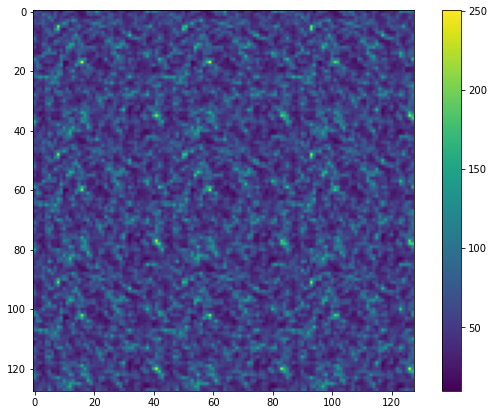

In [69]:
from matplotlib import colors
from matplotlib import pyplot as plt
plt.figure(figsize=(10,7))
plt.imshow(delta[:,:,80])#,norm=colors.LogNorm())
plt.colorbar()
plt.show()